This notebook is used to train the models using `MLFLow`, if you want to see the results for the best models, refer to the `4_evaluation` notebook.

In [36]:
import os

import mlflow
from mlflow.models import infer_signature
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

os.sys.path.append(os.path.abspath('../src'))
from data import loader
from data import preprocessor

mapname = 'Town01'

In [6]:
def create_and_train_model(model, args):
    """
    Function to create and train a model with given parameters.

    Args:
        model: The model to be trained.
        args: Arguments for training the model.

    Returns:
        result: The result of the training process.
    """
    result = {}
    # Train model with current hyperparameters
    print(f"Params: {args}")
    md = model(**args)
    md.fit(X_train, y_train)
    # Predict on the validation set
    y_pred = md.predict(X_val)
    # Log training results
    result["f1_score"] = f1_score(y_val, y_pred, average='weighted')
    result["accuracy"] = accuracy_score(y_val, y_pred)
    result["recall"] = recall_score(y_val, y_pred, average='weighted')
    result["precision"] = precision_score(y_val, y_pred, average='weighted')
    result["model"] = md

    return result

In [7]:
def objective(params, model_name):
    """
    Objective function for hyperparameter optimization.
    This function will be called by Hyperopt for each trial.
    """
    with mlflow.start_run(nested=True, run_name=f"{model_name}_{params}"):
        # Log hyperparameters being tested
        mlflow.log_params(params)

        # Train model with current hyperparameters
        result = create_and_train_model(
            model,
            args=params
        )

        # Log training results
        mlflow.log_metrics(
            {
                "accuracy": result["accuracy"],
                "recall": result["recall"],
                "precision": result["precision"],
                "f1_score": result["f1_score"],
            }
        )

        # Log the trained model
        mlflow.sklearn.log_model(
            result["model"], name=model_name, signature=signature)

        # Return loss for Hyperopt (it minimizes)
        return {"loss": -result["f1_score"], "status": STATUS_OK, "model": f'{model_name}_{params}'}

In [8]:
def run_experiments(run_name, max_evals, search_space, data_name, features_names, model_name):
    # Create or set experiment

    print(
        f"This will run {max_evals} trials to find optimal hyperparameters...")

    with mlflow.start_run(run_name=run_name):

        mlflow.set_tag("model_type", model_name)

        # Log experiment metadata
        mlflow.log_params(
            {
                "optimization_method": "Tree-structured Parzen Estimator (TPE)",
                "max_evaluations": max_evals,
                "objective_metric": "log_loss",
                "dataset": data_name,
                "features": features_names,
            }
        )

        # Run optimization
        trials = Trials()
        objective_with_name = partial(objective, model_name=model_name)

        best_params = fmin(
            fn=objective_with_name,
            space=search_space,
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=trials,
            verbose=True,
        )

        # Find and log best results
        best_trial = min(trials.results, key=lambda x: x["loss"])
        best_f1_score = -best_trial["loss"]

        # Log optimization results
        mlflow.log_params(best_params)
        mlflow.log_params({"best_model": best_trial["model"]})
        mlflow.log_metrics(
            {
                "best_f1_score": best_f1_score,
                "total_trials": len(trials.trials),
                "optimization_completed": 1,
            }
        )

    return best_f1_score 


In [45]:
def save_umap(embeddings, labels, title, figs_path='../results/figures/umap'):

    # Create a boolean mask for each class
    mask_real = labels == 0
    mask_sumo = labels == 1

    plt.figure(figsize=(6, 6))

    # Plot each class with a label
    plt.scatter(
        embeddings[mask_real, 0],
        embeddings[mask_real, 1],
        color='blue',
        s=2,
        label='Real'
    )

    plt.scatter(
        embeddings[mask_sumo, 0],
        embeddings[mask_sumo, 1],
        color='red',
        s=2,
        label='SUMO'
    )

    plt.legend(markerscale=4)  # Increase marker size in legend
    plt.title(title)
    plt.savefig(f'{figs_path}/{"_".join(title.lower().split())}.png')
    plt.show()

In [9]:
client = mlflow.tracking.MlflowClient("http://127.0.0.1:8080")
mlflow.set_tracking_uri("http://127.0.0.1:8080")

## Preparing the Data

In [10]:
data_path = '../data'
uah_training = pd.read_csv(f'{data_path}/base/training_set_uah.csv')
uah_validation = pd.read_csv(f'{data_path}/base/validation_set_uah.csv')

carla_fixed = pd.read_csv(f'{data_path}/merged/{mapname}/carla/carla_fixed.csv').drop(columns=['origin'])
carla_llm = pd.read_csv(f'{data_path}/merged/{mapname}/carla/carla_llm.csv').drop(columns=['origin'])

sumo_fixed = pd.read_csv(f'{data_path}/merged/{mapname}/sumo/sumo_fixed.csv').drop(columns=['origin'])
sumo_llm = pd.read_csv(f'{data_path}/merged/{mapname}/sumo/sumo_llm.csv').drop(columns=['origin'])

carla_uah_fixed = pd.read_csv(f'{data_path}/merged/{mapname}/carla_uah/carla_uah_fixed.csv')
carla_uah_llm = pd.read_csv(f'{data_path}/merged/{mapname}/carla_uah/carla_uah_llm.csv')

sumo_uah_fixed = pd.read_csv(f'{data_path}/merged/{mapname}/sumo_uah/sumo_uah_fixed.csv')
sumo_uah_llm = pd.read_csv(f'{data_path}/merged/{mapname}/sumo_uah/sumo_uah_llm.csv')

In [11]:
sumo_columns_to_keep = sumo_fixed.columns.tolist()
carla_columns_to_keep = carla_fixed.columns.tolist()

In [12]:
window_size = 10
step_size = 5
one_hot_keys = {
    'normal': 0,
    'aggressive': 1
}

Defining the search space for each model

In [13]:
max_evals = 5

search_space_rf = {
    "n_estimators": hp.choice("n_estimators", [20, 50, 100, 200, 500]),
    "max_depth": hp.choice("max_depth", [None, 5, 10, 20, 50]),
    "random_state": 42,
}
search_space_svc = {
    "C": hp.choice("C", [0.01, 0.05, 0.1, 0.5, 1]),  # Regularization parameter
    "kernel": hp.choice("kernel", ["rbf"]),  # Kernel type
    "gamma": hp.choice("gamma", [0.001, 0.01, 0.1, 1, 10]),  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}
search_space_svc_linear = {
    "C": hp.choice("C", [10**-4, 10**-3, 10**-2, 0.1, 1])  # Regularization parameter
}
search_space_xgb = {
    "n_estimators": hp.choice("n_estimators", [200, 500, 700, 1000]),
    "max_depth": hp.choice("max_depth", [None, 5, 10]),
    "learning_rate": hp.choice("learning_rate", [0.001, 0.01, 0.1, 0.2, 0.3]),  # Learning rate
    "subsample": hp.choice("subsample", [0.5, 0.7, 1.0]),  # Subsample ratio of the training instances
    "colsample_bytree": hp.choice("colsample_bytree", [0.5, 0.7, 1.0]),  # Subsample ratio of columns when constructing each tree
}

# Train on Real test on Synthetic

By training a model on real data and testing on synthetic data, we verify synthetic data’s fidelity with the real-world.

## SUMO

In [10]:
X_train, y_train = preprocessor.sliding_windows(uah_training[sumo_columns_to_keep], window_size=10, step_size=5)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys)
signature = infer_signature(X_train, y_train)

### Fixed

In [11]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to TRTS on SUMO Fixed data."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="TRTS_SUMO_Fixed", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [12]:
X_val, y_val = preprocessor.sliding_windows(sumo_fixed, window_size=10, step_size=5)
y_val = preprocessor.one_hot_encode(y_val, one_hot_keys)

mlflow.set_experiment('TRTS_SUMO_Fixed')
data_name = 'TRTS_SUMO_Fixed'

In [13]:
model = RandomForestClassifier
run_experiments('trts-rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=sumo_columns_to_keep)
model = SVC
run_experiments('trts-svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=sumo_columns_to_keep)
model = xgb.XGBClassifier
run_experiments('trts-xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=sumo_columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 50, 'n_estimators': 20, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 20, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/691238700685919333/runs/d1f2b878a0484266bb08ba7a00144d08

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/691238700685919333

Params: {'max_depth': 50, 'n_estimators': 20, 'random_state': 42}                
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 20, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/691238700685919333/runs/8c23b125639640c9b5a0328bcba6c81f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/691238700685919333    

Params: {'max_depth': None, 'n_estimators': 200, 'random_state': 42}             
🏃 View run RandomForestClassifier_{'max_depth': None, 'n_estimators': 200, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/691238700685919333/runs/54b6ddd4d7504

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/691238700685919333/runs/8476c277c090461fba3d9f634b977a29

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/691238700685919333    

Params: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}                                  
 60%|██████    | 3/5 [04:09<02:55, 87.74s/trial, best loss: -0.32535705835327683]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/691238700685919333/runs/b04d978f22b24090b2af3772369762a9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/691238700685919333    

Params: {'C': 0.5, 'gamma': 10, 'kernel': 'rbf'}                                 
 80%|████████  | 4/5 [05:25<01:23, 83.08s/trial, best loss: -0.32535705835327683]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/691238700685919333/runs/dfa65d4940b34a97beb1bd93409c6d4b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/691238700685919333    

100%|██████████| 5/5 [07:09<00:00, 85.86s/trial, best loss: -0.32535705835327683]
🏃 View run trts-svc-sweep at: http://127.0.0.1:8080/#/experiments/691238700685919333/runs/25bcbb8206f343afba0daa6ef7c319ac
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/691238700685919333
This will run 5 trials to find optimal hyperparameters...
Params: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': None, 'n_estimators': 700, 'subsample': 1.0}
🏃 View run XGBClassifier_{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': None, 'n_estimators': 700, 'subsample': 1.0} at: http://127.0.0.1:8080/#/experiments/691238700685919333/runs/d3499120bc1e462aabc3b17a3a8dc56b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/691238700685919333

Par

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run XGBClassifier_{'colsample_bytree': 1.0, 'learning_rate': 0.001, 'max_depth': None, 'n_estimators': 200, 'subsample': 1.0} at: http://127.0.0.1:8080/#/experiments/691238700685919333/runs/71b44a5d2fc3412d8a344b592d228f83

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/691238700685919333    

Params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.5}
🏃 View run XGBClassifier_{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.5} at: http://127.0.0.1:8080/#/experiments/691238700685919333/runs/056b700c94ba4c2eb62d13eeed310861

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/691238700685919333    

Params: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': None, 'n_estimators': 700, 'subsample': 0.5}
🏃 View run XGBClassifier_{'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': None, 'n_estimators': 700, 'subsample': 0.5} at: http://127.0.

0.4628341944440826

### LLM

In [14]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to TRTS on SUMO LLM data."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="TRTS_SUMO_LLM", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [15]:
X_val, y_val = preprocessor.sliding_windows(sumo_llm, window_size=10, step_size=5)
y_val = preprocessor.one_hot_encode(y_val, one_hot_keys)

mlflow.set_experiment('TRTS_SUMO_LLM')
data_name = 'TRTS_SUMO_LLM'

In [16]:
model = RandomForestClassifier
run_experiments('trts-rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=sumo_columns_to_keep)
model = SVC
run_experiments('trts-svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=sumo_columns_to_keep)
model = xgb.XGBClassifier
run_experiments('trts-xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=sumo_columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 20, 'n_estimators': 500, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 500, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/809324753489057368/runs/022b2d2f95c341589b4c8036506d65c0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/809324753489057368

Params: {'max_depth': 50, 'n_estimators': 500, 'random_state': 42}              
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 500, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/809324753489057368/runs/067804f43fd44201a680cecae695cae1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/809324753489057368   

Params: {'max_depth': 50, 'n_estimators': 100, 'random_state': 42}              
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 100, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/809324753489057368/runs/464726469ba64a2

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/809324753489057368/runs/156c82c20e1947b2a6bd807ede8bb54b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/809324753489057368

Params: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}                               
 20%|██        | 1/5 [01:37<06:30, 97.66s/trial, best loss: -0.366294641495687]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/809324753489057368/runs/e56e98e1b9db4376bc1a76c9185b8285

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/809324753489057368  

Params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}                                
🏃 View run SVC_{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/809324753489057368/runs/b902853477474694809e36afcdbf964a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/809324753489057368  

Params: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}                                  
 60%|██████    | 3/5 [03:51<02:23, 71.92s/trial, best loss: -0.366294641495687]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/809324753489057368/runs/b2b17290cca4428f850854828327d3d7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/809324753489057368  

Params: {'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'}                            
🏃 View run SVC_{'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/809324753489057368/runs/36c7151bc4274ed89c02905cdb209175

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/809324753489057368  

100%|██████████| 5/5 [06:40<00:00, 80.09s/trial, best loss: -0.366294641495687]
🏃 View run trts-svc-sweep at: http://127.0.0.1:8080/#/experiments/809324753489057368/runs/d8cf8a9b39654ce5821c60750724ffbd
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/809324753489057368
This will run 5 trials to find optimal hyperparameters...
Params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 700, 'subsample': 0.7}
🏃

0.44974473749821314

## CARLA

In [17]:
X_train, y_train = preprocessor.sliding_windows(uah_training[carla_columns_to_keep], window_size=10, step_size=5)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys)
signature = infer_signature(X_train, y_train)

### Fixed

In [18]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to TRTS on CARLA Fixed data."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="TRTS_CARLA_Fixed", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [19]:
X_val, y_val = preprocessor.sliding_windows(carla_fixed, window_size=10, step_size=5)
y_val = preprocessor.one_hot_encode(y_val, one_hot_keys)

mlflow.set_experiment('TRTS_CARLA_Fixed')
data_name = 'TRTS_CARLA_Fixed'

In [20]:
model = RandomForestClassifier
run_experiments('trts-rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=sumo_columns_to_keep)
model = SVC
run_experiments('trts-svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=sumo_columns_to_keep)
model = xgb.XGBClassifier
run_experiments('trts-xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=sumo_columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 5, 'n_estimators': 20, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 20, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/386847239332001868/runs/485f251081bf45ae94685873d4be2673

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/386847239332001868

Params: {'max_depth': 20, 'n_estimators': 500, 'random_state': 42}               
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 500, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/386847239332001868/runs/6224815e78764ec0a30706d2a7a126f1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/386847239332001868    

Params: {'max_depth': 20, 'n_estimators': 50, 'random_state': 42}                
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 50, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/386847239332001868/runs/ae8c6ebbba014bacb

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/386847239332001868/runs/13fe387646224bc3aed481aef21a671b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/386847239332001868

Params: {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}                            
 20%|██        | 1/5 [00:58<03:52, 58.21s/trial, best loss: -0.4209539786453059]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/386847239332001868/runs/8574de304cec4819a84b91f6faf605fe

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/386847239332001868   

Params: {'C': 0.5, 'gamma': 10, 'kernel': 'rbf'}                                
 40%|████      | 2/5 [01:57<02:56, 58.89s/trial, best loss: -0.4209539786453059]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/386847239332001868/runs/1b73576687904db9b6c092e24b4f3069

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/386847239332001868   

Params: {'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}                               
 60%|██████    | 3/5 [03:15<02:15, 67.62s/trial, best loss: -0.4209539786453059]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/386847239332001868/runs/bad8fdc75d9f47518f7990a15b31da8e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/386847239332001868   

Params: {'C': 0.05, 'gamma': 0.01, 'kernel': 'rbf'}                             
 80%|████████  | 4/5 [03:57<00:57, 57.47s/trial, best loss: -0.4209539786453059]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/386847239332001868/runs/c635d0353e17451487ace7ff5c98282c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/386847239332001868   

100%|██████████| 5/5 [04:53<00:00, 58.76s/trial, best loss: -0.4209539786453059]
🏃 View run trts-svc-sweep at: http://127.0.0.1:8080/#/experiments/386847239332001868/runs/76f06e9267ea4678a7f48d428d7f6e41
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/386847239332001868
This will run 5 trials to find optimal hyperparameters...
Params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.7}
🏃 View run XGBClassifier_{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.7} at: http://127.0.0.1:8080/#/experiments/386847239332001868/runs/0c3b949b98384816a6d64b60f76a1dba

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/386847239332001868

Pa

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run XGBClassifier_{'colsample_bytree': 0.5, 'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5} at: http://127.0.0.1:8080/#/experiments/386847239332001868/runs/fc17520af75c434283d9d33fd030833e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/386847239332001868    

100%|██████████| 5/5 [00:52<00:00, 10.47s/trial, best loss: -0.4209539786453059] 
🏃 View run trts-xgb-sweep at: http://127.0.0.1:8080/#/experiments/386847239332001868/runs/933da62eaa814862b242fd5795a4c4ef
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/386847239332001868


0.4209539786453059

### LLM

In [21]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to TRTS on CARLA LLM data."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="TRTS_CARLA_LLM", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [22]:
X_val, y_val = preprocessor.sliding_windows(carla_llm, window_size=10, step_size=5)
y_val = preprocessor.one_hot_encode(y_val, one_hot_keys)

mlflow.set_experiment('TRTS_CARLA_LLM')
data_name = 'TRTS_CARLA_LLM'

In [23]:
model = RandomForestClassifier
run_experiments('trts-rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=sumo_columns_to_keep)
model = SVC
run_experiments('trts-svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=sumo_columns_to_keep)
model = xgb.XGBClassifier
run_experiments('trts-xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=sumo_columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 5, 'n_estimators': 200, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 200, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/329550000572282095/runs/4db269a7759846e2b2a21bb9686ec966

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/329550000572282095

Params: {'max_depth': 50, 'n_estimators': 20, 'random_state': 42}                
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 20, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/329550000572282095/runs/959dbb1679a84aa0b2369b41213f6ed0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/329550000572282095    

Params: {'max_depth': None, 'n_estimators': 100, 'random_state': 42}             
🏃 View run RandomForestClassifier_{'max_depth': None, 'n_estimators': 100, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/329550000572282095/runs/f447d3597df84

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/329550000572282095/runs/d30ccbbaf869493fb48b3563f4e41d7a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/329550000572282095

Params: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}                                
 20%|██        | 1/5 [01:02<04:11, 62.97s/trial, best loss: -0.2881971054975632]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/329550000572282095/runs/d6e8080e38d44a35b52d703fa38dab83

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/329550000572282095   

Params: {'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'}                             
 40%|████      | 2/5 [01:54<02:48, 56.00s/trial, best loss: -0.3805192649733608]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/329550000572282095/runs/e03fdeeb7c2a45daa19b0d4ffb35226f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/329550000572282095   

Params: {'C': 0.05, 'gamma': 10, 'kernel': 'rbf'}                               
 60%|██████    | 3/5 [02:55<01:57, 58.58s/trial, best loss: -0.3805192649733608]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/329550000572282095/runs/eb2b86d4795c421291aa6b7a589158ce

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/329550000572282095   

Params: {'C': 0.05, 'gamma': 10, 'kernel': 'rbf'}                               
 80%|████████  | 4/5 [04:00<01:01, 61.12s/trial, best loss: -0.3805192649733608]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/329550000572282095/runs/71f4686ff89343fcae702c26fde41e47

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/329550000572282095   

100%|██████████| 5/5 [05:08<00:00, 61.68s/trial, best loss: -0.3805192649733608]
🏃 View run trts-svc-sweep at: http://127.0.0.1:8080/#/experiments/329550000572282095/runs/1ab19be46c5e4711b2d6b649b96e976c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/329550000572282095
This will run 5 trials to find optimal hyperparameters...
Params: {'colsample_bytree': 1.0, 'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5}
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run XGBClassifier_{'colsample_bytree': 1.0, 'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5} at: http://127.0.0.1:8080/#/experiments/329550000572282095/runs/8f521e3cbfe54e31ac0f0f267053f1d3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/329550000572282095

Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5}
🏃 View run XGBClassifier_{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5} at: http://127.0.0.1:8080/#/experiments/329550000572282095/runs/6d22714e58424359a7e5ac2b8322c043

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/329550000572282095   

Params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 700, 'subsample': 0.7}
🏃 View run XGBClassifier_{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 700, 'subsample': 0.7} at: http://127.0.0.1:8080/#

0.5313242721538347

# Discriminative Score and UMAP

We seek to understand how well a classifier can separate the real and the synthetic data to determine how indistiguishable they are.

Here, there is no need to fine-tune hyperparameters, since the default parameters work.

We are also going to plot the UMAP projection of the data, to see how separated it is.

In [47]:
X_uah_disc_sumo = uah_training[sumo_columns_to_keep].drop(columns=['label'])
X_uah_disc_carla = uah_training[carla_columns_to_keep].drop(columns=['label'])
y_uah_disc = np.zeros(len(X_uah_disc_carla)) # 0 for real data and 1 for synthetic data

## SUMO

In [49]:
X_sumo_disc_fixed, y_sumo_disc_fixed = sumo_fixed.drop(columns=['label']), np.ones(len(sumo_fixed))
X_sumo_disc_llm, y_sumo_disc_llm = sumo_llm.drop(columns=['label']), np.ones(len(sumo_llm))

### Fixed

In [59]:
X, y = pd.concat([X_sumo_disc_fixed, X_uah_disc_sumo], axis=0, ignore_index=True), np.concat([y_sumo_disc_fixed, y_uah_disc], axis=0)
X.reset_index(drop=True, inplace=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [27]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(f"F1 Score: {f1_score(y_val, y_pred, average='weighted')}")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")

F1 Score: 1.0
Accuracy: 1.0


/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


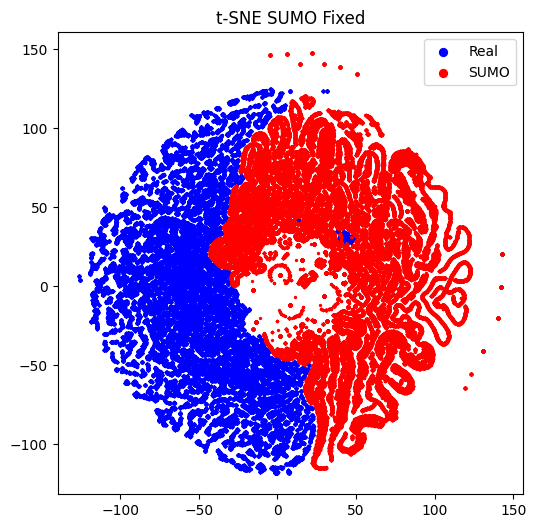

In [60]:
data = X.values
scaled_data = StandardScaler().fit_transform(data)
reducer = TSNE(n_components=2, perplexity=30, n_iter=1000)
sumo_fixed_embedding = reducer.fit_transform(scaled_data)
save_umap(sumo_fixed_embedding, y, 't-SNE SUMO Fixed')

### LLM

In [61]:
X, y = pd.concat([X_sumo_disc_llm, X_uah_disc_sumo], axis=0, ignore_index=True), np.concat([y_sumo_disc_llm, y_uah_disc], axis=0)
X.reset_index(drop=True, inplace=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [54]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(f"F1 Score: {f1_score(y_val, y_pred, average='weighted')}")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")

KeyboardInterrupt: 

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


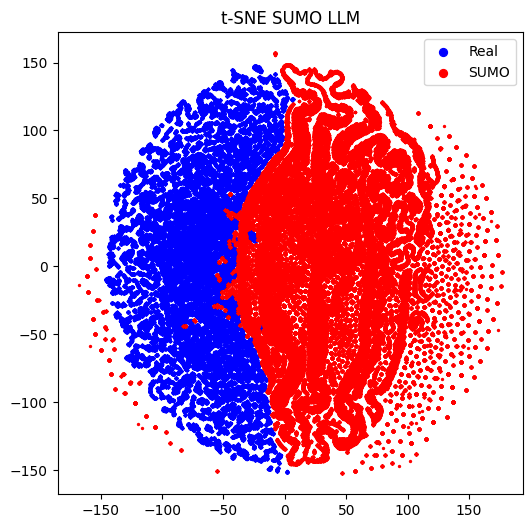

In [62]:
data = X.values
scaled_data = StandardScaler().fit_transform(data)
reducer = TSNE(n_components=2, perplexity=30, n_iter=1000)
sumo_llm_embedding = reducer.fit_transform(scaled_data)
save_umap(sumo_llm_embedding, y, 't-SNE SUMO LLM')

## CARLA

In [63]:
X_carla_disc_fixed, y_carla_disc_fixed = carla_fixed.drop(columns=['label']), np.ones(len(carla_fixed))
X_carla_disc_llm, y_carla_disc_llm = carla_llm.drop(columns=['label']), np.ones(len(carla_llm))

### Fixed

In [64]:
X, y = pd.concat([X_carla_disc_fixed, X_uah_disc_carla], axis=0, ignore_index=True), np.concat([y_carla_disc_fixed, y_uah_disc], axis=0)
X.reset_index(drop=True, inplace=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(f"F1 Score: {f1_score(y_val, y_pred, average='weighted')}")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")

F1 Score: 1.0
Accuracy: 1.0


/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


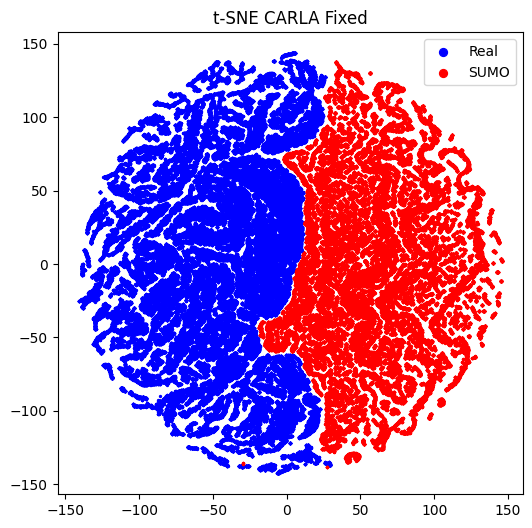

In [65]:
data = X.values
scaled_data = StandardScaler().fit_transform(data)
reducer = TSNE(n_components=2, perplexity=30, n_iter=1000)
carla_fixed_embedding = reducer.fit_transform(scaled_data)
save_umap(carla_fixed_embedding, y, 't-SNE CARLA Fixed')

### LLM

In [66]:
X, y = pd.concat([X_carla_disc_llm, X_uah_disc_carla], axis=0, ignore_index=True), np.concat([y_carla_disc_llm, y_uah_disc], axis=0)
X.reset_index(drop=True, inplace=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(f"F1 Score: {f1_score(y_val, y_pred, average='weighted')}")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")

F1 Score: 1.0
Accuracy: 1.0


/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


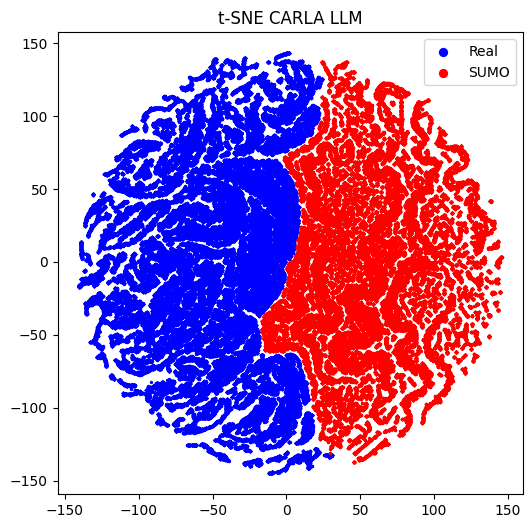

In [67]:
data = X.values
scaled_data = StandardScaler().fit_transform(data)
reducer = TSNE(n_components=2, perplexity=30, n_iter=1000)
carla_llm_embedding = reducer.fit_transform(scaled_data)
save_umap(carla_llm_embedding, y, 't-SNE CARLA LLM')

# Predictive Scores

Here we train on different combinations of real and synthetic data and test on real data only in order to verify the quality of the data for real-world applications.

## Real Only

In [39]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH driveset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [40]:
columns_to_keep = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'angle', 'speed', 'label']

X_train, y_train = preprocessor.sliding_windows(uah_training[columns_to_keep], window_size=window_size, step_size=step_size)
X_val, y_val = preprocessor.sliding_windows(uah_validation[columns_to_keep], window_size=window_size, step_size=step_size)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)
y_val = preprocessor.one_hot_encode(y_val, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH')
data_name = 'UAH'

In [41]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 50, 'n_estimators': 50, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 50, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/909610640582434158/runs/d7a6aa5493344524b304b56d2f0c1540

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/909610640582434158

Params: {'max_depth': None, 'n_estimators': 500, 'random_state': 42}           
🏃 View run RandomForestClassifier_{'max_depth': None, 'n_estimators': 500, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/909610640582434158/runs/154c35dbaf914a5aa8d1dc95043b5abf

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/909610640582434158  

Params: {'max_depth': None, 'n_estimators': 500, 'random_state': 42}           
🏃 View run RandomForestClassifier_{'max_depth': None, 'n_estimators': 500, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/909610640582434158/runs/f41add9eb0b04918

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/909610640582434158/runs/365668037f3244f785c7d409825ce857

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/909610640582434158

Params: {'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}                                
 20%|██        | 1/5 [02:06<08:27, 126.86s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/909610640582434158/runs/a1a1341bc91246d2934caa83891e095c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/909610640582434158    

Params: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}                                 
 40%|████      | 2/5 [03:43<05:26, 108.91s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/909610640582434158/runs/49a592b9cedd47419572106050be8314

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/909610640582434158    

Params: {'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}                                
 60%|██████    | 3/5 [04:57<03:05, 92.90s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/909610640582434158/runs/dd5677fc00e84c53aeaace8adb7a5ad9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/909610640582434158   

Params: {'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}                               
🏃 View run SVC_{'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/909610640582434158/runs/0f5001c6710e4a429db0c9225d84351f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/909610640582434158   

100%|██████████| 5/5 [07:33<00:00, 90.69s/trial, best loss: -0.7449274665292777]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/909610640582434158/runs/5417db442fe9493d8198ff33c22367d9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/909610640582434158
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 0.001}                                 
🏃 View run LinearSVC_{'C': 0.001} at: http://127.0.0.1:8080

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run XGBClassifier_{'colsample_bytree': 0.5, 'learning_rate': 0.001, 'max_depth': None, 'n_estimators': 200, 'subsample': 0.5} at: http://127.0.0.1:8080/#/experiments/909610640582434158/runs/410540674dab4bdf8b995c078f5cebed

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/909610640582434158  

Params: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 1000, 'subsample': 1.0}
🏃 View run XGBClassifier_{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 1000, 'subsample': 1.0} at: http://127.0.0.1:8080/#/experiments/909610640582434158/runs/89e02c0008db4b3d9bb77aca5ac97998

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/909610640582434158  

100%|██████████| 5/5 [00:31<00:00,  6.26s/trial, best loss: -0.779620637655797]
🏃 View run xgb-sweep at: http://127.0.0.1:8080/#/experiments/909610640582434158/runs/cc43505f2a4f4736acfe6b12e81d03ad
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/90961064

0.779620637655797

## SUMO Only

In [42]:
# SUMO
X_sumo_fixed, y_sumo_fixed = preprocessor.sliding_windows(sumo_fixed, window_size=window_size, step_size=step_size)
X_sumo_llm, y_sumo_llm = preprocessor.sliding_windows(sumo_llm, window_size=window_size, step_size=step_size)

In [43]:
# Getting the validation for SUMO variables
print("Columns to keep for validation:", sumo_columns_to_keep)

X_val_base, y_val = preprocessor.sliding_windows(uah_validation[sumo_columns_to_keep], window_size=window_size, step_size=step_size)
y_val = preprocessor.one_hot_encode(y_val, one_hot_keys=one_hot_keys)

Columns to keep for validation: ['acc', 'angle', 'speed', 'gyro_z', 'label']


### Fixed

In [44]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the SUMO Fixed dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="SUMO_Fixed", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [45]:
X_train, y_train = X_sumo_fixed, y_sumo_fixed

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('SUMO_Fixed')
data_name = 'SUMO_Fixed'

In [46]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 10, 'n_estimators': 200, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 200, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/550988817141560277/runs/abfbf35edf5947f88cd02228c554059d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/550988817141560277

Params: {'max_depth': None, 'n_estimators': 500, 'random_state': 42}             
 20%|██        | 1/5 [00:18<01:13, 18.48s/trial, best loss: -0.33671100692668154]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run RandomForestClassifier_{'max_depth': None, 'n_estimators': 500, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/550988817141560277/runs/b84154e19e0a4c57aa3eafb495b9fd44

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/550988817141560277    

Params: {'max_depth': 10, 'n_estimators': 50, 'random_state': 42}                
 40%|████      | 2/5 [01:39<02:45, 55.13s/trial, best loss: -0.33671100692668154]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 50, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/550988817141560277/runs/1f6c99aaee924425b3b5ce8cdd7013e7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/550988817141560277    

Params: {'max_depth': 20, 'n_estimators': 200, 'random_state': 42}               
 60%|██████    | 3/5 [01:44<01:05, 32.54s/trial, best loss: -0.33671100692668154]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 200, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/550988817141560277/runs/fd847e47721f41b0ab8b449efdeaa18a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/550988817141560277    

Params: {'max_depth': 10, 'n_estimators': 200, 'random_state': 42}               
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 200, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/550988817141560277/runs/8eca37b77f9746aa83c0a8f62bdfd7e7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/550988817141560277    

100%|██████████| 5/5 [02:30<00:00, 30.15s/trial, best loss: -0.33671100692668154]
🏃 View run rf-sweep at: http://127.0.0.1:8080/#/experiments/550988817141560277/runs/1c0d7f538d4f4a04a6c9a1d4350bc21f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/550988817141560277
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 1, 'gamma': 10, 'kernel'

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/550988817141560277/runs/c4fd8c0b35724f2e874d485f5cf7b16e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/550988817141560277

Params: {'C': 0.05, 'gamma': 1, 'kernel': 'rbf'}                                  
 20%|██        | 1/5 [03:13<12:54, 193.67s/trial, best loss: -0.33310749162724596]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/550988817141560277/runs/2814a828e55840de86d8b43b1cad114c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/550988817141560277     

Params: {'C': 0.05, 'gamma': 1, 'kernel': 'rbf'}                                  
 40%|████      | 2/5 [04:21<05:58, 119.55s/trial, best loss: -0.33310749162724596]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/550988817141560277/runs/f24ad8f267c74683b55ca2e83a2297f1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/550988817141560277     

Params: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}                               
 60%|██████    | 3/5 [05:28<03:11, 95.63s/trial, best loss: -0.33310749162724596]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/550988817141560277/runs/456e88f389dd427db49a68fd44f1c8cf

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/550988817141560277    

Params: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}                              
 80%|████████  | 4/5 [06:47<01:29, 89.04s/trial, best loss: -0.33310749162724596]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/550988817141560277/runs/0b8b322b305d4e0f8de39024d655e40a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/550988817141560277    

100%|██████████| 5/5 [08:06<00:00, 97.29s/trial, best loss: -0.33310749162724596]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/550988817141560277/runs/f2585f31e0c244b7842e71ef32b8e0b3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/550988817141560277
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 0.001}                                 
🏃 View run LinearSVC_{'C': 0.001} at: http://127.0.0.1:8080/#/experiments/550988817141560277/runs/5470c5b7f0434f329fa1fab22a6422cf

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/550988817141560277

Params: {'C': 1}                                                                
🏃 View run LinearSVC_{'C': 1} at: http://127.0.0.1:8080/#/experiments/55098881714

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run XGBClassifier_{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5} at: http://127.0.0.1:8080/#/experiments/550988817141560277/runs/c3b00caf72de432eadc9ddd9f25eefe3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/550988817141560277    

Params: {'colsample_bytree': 0.7, 'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 700, 'subsample': 0.7}
 80%|████████  | 4/5 [00:21<00:04,  4.41s/trial, best loss: -0.33730962743803933]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run XGBClassifier_{'colsample_bytree': 0.7, 'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 700, 'subsample': 0.7} at: http://127.0.0.1:8080/#/experiments/550988817141560277/runs/c953b442e7c54375834c33460c332c54

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/550988817141560277    

100%|██████████| 5/5 [00:24<00:00,  4.82s/trial, best loss: -0.33730962743803933]
🏃 View run xgb-sweep at: http://127.0.0.1:8080/#/experiments/550988817141560277/runs/ae11a859acc14eba99c1f4b5ead74fd0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/550988817141560277


0.33730962743803933

### LLM

In [47]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the SUMO LLM dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="SUMO_LLM", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [48]:
X_train, y_train = X_sumo_llm, y_sumo_llm

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

mlflow.set_experiment('SUMO_LLM')
data_name = 'SUMO_LLM'

In [49]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 20, 'n_estimators': 50, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 50, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/664414606457528437/runs/2e8e2140ad1b42a9ae2968ea0c72b190

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/664414606457528437

Params: {'max_depth': 50, 'n_estimators': 100, 'random_state': 42}               
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 100, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/664414606457528437/runs/dade9712c4b346d0b72d343ad7328452

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/664414606457528437    

Params: {'max_depth': 10, 'n_estimators': 500, 'random_state': 42}               
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 500, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/664414606457528437/runs/d87bafc2c5c54a

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/664414606457528437/runs/8469d52b018e460abf4f912a04468dd7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/664414606457528437

Params: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}                                  
 20%|██        | 1/5 [02:11<08:46, 131.55s/trial, best loss: -0.33310749162724596]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/664414606457528437/runs/95dbac10b5b340788b50309a3bd8a33f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/664414606457528437     

Params: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}                                  
 40%|████      | 2/5 [03:44<05:26, 108.89s/trial, best loss: -0.33310749162724596]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/664414606457528437/runs/820d7a05789946e19187274dbe5d920a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/664414606457528437     

Params: {'C': 0.05, 'gamma': 1, 'kernel': 'rbf'}                                  
 60%|██████    | 3/5 [05:19<03:25, 102.72s/trial, best loss: -0.33310749162724596]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/664414606457528437/runs/0b07d6cb31944ecab067405fc7421458

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/664414606457528437     

Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}                                 
 80%|████████  | 4/5 [07:19<01:49, 109.49s/trial, best loss: -0.33310749162724596]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/664414606457528437/runs/24549af7e7e84ad4abd4aa9bfff4f2c2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/664414606457528437     

100%|██████████| 5/5 [08:44<00:00, 104.89s/trial, best loss: -0.33310749162724596]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/664414606457528437/runs/5433938ec76a41c49ac8d02a9eb98e55
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/664414606457528437
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 0.01}                                  
🏃 View run LinearSVC_{'C': 0.01} at: http://127.0.0.1:8080/#/experiments/664414606457528437/runs/289f89e5f96845739cab9a861be21c86

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/664414606457528437

Params: {'C': 0.0001}                                                           
🏃 View run LinearSVC_{'C': 0.0001} at: http://127.0.0.1:8080/#/experiments/6644146

0.5726197757662195

## Carla Only

In [50]:
X_carla_fixed, y_carla_fixed = preprocessor.sliding_windows(carla_fixed, window_size=window_size, step_size=step_size)
X_carla_llm, y_carla_llm = preprocessor.sliding_windows(carla_llm, window_size=window_size, step_size=step_size)

In [51]:
# Getting the validation for SUMO variables
print("Columns to keep for validation:", carla_columns_to_keep)
X_val_base, y_val = preprocessor.sliding_windows(uah_validation[carla_columns_to_keep], window_size=window_size, step_size=step_size)
y_val = preprocessor.one_hot_encode(y_val, one_hot_keys=one_hot_keys)

Columns to keep for validation: ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'angle', 'label', 'acc']


### Fixed

In [52]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the CARLA Fixed dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="CARLA_Fixed", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [53]:
X_train, y_train = X_carla_fixed, y_carla_fixed

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

mlflow.set_experiment('CARLA_Fixed')
data_name = 'CARLA_Fixed'

In [54]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 20, 'n_estimators': 100, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 100, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/627946991416594886/runs/9ca1932a0bfc487d8775c5f0613660e9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/627946991416594886

Params: {'max_depth': 20, 'n_estimators': 200, 'random_state': 42}              
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 200, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/627946991416594886/runs/d349833fdc214f2aaf1736221ae8ef24

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/627946991416594886   

Params: {'max_depth': 5, 'n_estimators': 20, 'random_state': 42}                
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 20, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/627946991416594886/runs/473b1642ebd941cc9

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/627946991416594886/runs/a2bf841987ba42b2b6b793ca5972ed4d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/627946991416594886

Params: {'C': 0.05, 'gamma': 10, 'kernel': 'rbf'}                                
 20%|██        | 1/5 [00:32<02:10, 32.55s/trial, best loss: -0.33310749162724596]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/627946991416594886/runs/3ed7326923a147aaade665a7a43ca663

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/627946991416594886    

Params: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}                                 
 40%|████      | 2/5 [00:58<01:25, 28.55s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/627946991416594886/runs/754c3c391ef24860be5d4ebb97e7a389

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/627946991416594886   

Params: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}                             
 60%|██████    | 3/5 [01:22<00:53, 26.76s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/627946991416594886/runs/3ddc6ef5bba948a994b822d5dd6fc00d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/627946991416594886   

Params: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}                                
 80%|████████  | 4/5 [01:55<00:29, 29.02s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/627946991416594886/runs/6bb82991652646448181dabffdf11677

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/627946991416594886   

100%|██████████| 5/5 [02:17<00:00, 27.53s/trial, best loss: -0.3335592240143389]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/627946991416594886/runs/0a227330ed3b481f96a86dcec5e78739
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/627946991416594886
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 0.0001}                                
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run LinearSVC_{'C': 0.0001} at: http://127.0.0.1:8080/#/experiments/627946991416594886/runs/94e428f835b24abfb55cc9d721d5c7e3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/627946991416594886

Params: {'C': 0.1}                                                               
🏃 View run LinearSVC_{'C': 0.1} at: http://127.0.0.1:8080/#/experiments/627946991416594886/runs/bcc350a5f91d4d3fa72a95b663664b3f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/627946991416594886    

Params: {'C': 0.01}                                                              
🏃 View run LinearSVC_{'C': 0.01} at: http://127.0.0.1:8080/#/experiments/627946991416594886/runs/67bb933b2fc5434d82370ded847d4fb7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/627946991416594886   

Params: {'C': 1}                                                                
🏃 View run LinearSVC_{'C': 1} at: http://127.0.0.1:8080/#/experiments/627946991416594886/runs/16762b545ba04d6c984889ab0a

0.5486962349953002

### LLM

In [55]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the CARLA LLM dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="CARLA_LLM", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [56]:
X_train, y_train = X_carla_llm, y_carla_llm

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

mlflow.set_experiment('CARLA_LLM')
data_name = 'CARLA_LLM'

In [57]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 50, 'n_estimators': 100, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 100, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/366743456975286631/runs/eb7982ee6c224424ba7ad5e96d7a1fef

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/366743456975286631

Params: {'max_depth': 50, 'n_estimators': 100, 'random_state': 42}              
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 100, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/366743456975286631/runs/1ab40f6a77cd4bbaaf3fb2dd6e7c648d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/366743456975286631   

Params: {'max_depth': 50, 'n_estimators': 100, 'random_state': 42}              
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 100, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/366743456975286631/runs/590dfd9d2f0440d

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/366743456975286631/runs/1fc27c32e5e64abf9365bba54596e4c9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/366743456975286631

Params: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}                                  
 20%|██        | 1/5 [00:40<02:42, 40.59s/trial, best loss: -0.33310749162724596]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/366743456975286631/runs/b96dbfc2735a402fb09fd8a027399f03

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/366743456975286631    

Params: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}                                 
 40%|████      | 2/5 [01:35<02:26, 48.88s/trial, best loss: -0.33310749162724596]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/366743456975286631/runs/63b85517c4014e69957ec9d3b4f4b9f6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/366743456975286631    

Params: {'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'}                              
 60%|██████    | 3/5 [02:15<01:29, 44.87s/trial, best loss: -0.33310749162724596]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/366743456975286631/runs/f6ed22820be243ecb87cafb35edfd1b6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/366743456975286631    

Params: {'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}                                
 80%|████████  | 4/5 [02:51<00:41, 41.29s/trial, best loss: -0.33310749162724596]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/366743456975286631/runs/3eaae57b4be943c086818dfe7226939b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/366743456975286631    

100%|██████████| 5/5 [03:26<00:00, 41.34s/trial, best loss: -0.33310749162724596]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/366743456975286631/runs/efb5141b9be04721852e2da683912da2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/366743456975286631
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 0.001}                                 
🏃 View run LinearSVC_{'C': 0.001} at: http://127.0.0.1:8080/#/experiments/366743456975286631/runs/3ed659ce1e9142b3b5d211fe7e64149d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/366743456975286631

Params: {'C': 0.1}                                                              
🏃 View run LinearSVC_{'C': 0.1} at: http://127.0.0.1:8080/#/experiments/36674345697

0.5670418206707404

## Real + SUMO

In [58]:
sumo_uah_fixed_20 = preprocessor.fill_synthetic_data(sumo_uah_fixed, 0.2)
sumo_uah_llm_20 = preprocessor.fill_synthetic_data(sumo_uah_llm, 0.2)

sumo_uah_fixed_100 = preprocessor.fill_synthetic_data(sumo_uah_fixed, 1)
sumo_uah_llm_100 = preprocessor.fill_synthetic_data(sumo_uah_llm, 1)

sumo_uah_fixed_200 = preprocessor.fill_synthetic_data(sumo_uah_fixed, 2)
sumo_uah_llm_200 = preprocessor.fill_synthetic_data(sumo_uah_llm, 2)

In [59]:
X_sumo_uah_fixed_20, y_sumo_uah_fixed_20 = preprocessor.sliding_windows(sumo_uah_fixed_20, window_size=window_size, step_size=step_size)
X_sumo_uah_llm_20, y_sumo_uah_llm_20 = preprocessor.sliding_windows(sumo_uah_llm_20, window_size=window_size, step_size=step_size)

X_sumo_uah_fixed_100, y_sumo_uah_fixed_100 = preprocessor.sliding_windows(sumo_uah_fixed_100, window_size=window_size, step_size=step_size)
X_sumo_uah_llm_100, y_sumo_uah_llm_100 = preprocessor.sliding_windows(sumo_uah_llm_100, window_size=window_size, step_size=step_size)

X_sumo_uah_fixed_200, y_sumo_uah_fixed_200 = preprocessor.sliding_windows(sumo_uah_fixed_200, window_size=window_size, step_size=step_size)
X_sumo_uah_llm_200, y_sumo_uah_llm_200 = preprocessor.sliding_windows(sumo_uah_llm_200, window_size=window_size, step_size=step_size)

In [60]:
print("Columns to keep for validation:", sumo_columns_to_keep)

X_val_base, y_val = preprocessor.sliding_windows(uah_validation[sumo_columns_to_keep], window_size=window_size, step_size=step_size)
y_val = preprocessor.one_hot_encode(y_val, one_hot_keys=one_hot_keys)

Columns to keep for validation: ['acc', 'angle', 'speed', 'gyro_z', 'label']


## Real + SUMO (20%)

### Fixed

In [61]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + SUMO Fixed (20%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_SUMO_Fixed_20", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [62]:
X_train, y_train = X_sumo_uah_fixed_20, y_sumo_uah_fixed_20

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_SUMO_Fixed_20')
data_name = 'UAH_SUMO_Fixed_20'

In [63]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 20, 'n_estimators': 50, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 50, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/448063372140487283/runs/d70c4d4d074449dab73fbb3eb3a27f44

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/448063372140487283

Params: {'max_depth': 20, 'n_estimators': 500, 'random_state': 42}              
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 500, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/448063372140487283/runs/daa32febef6d4845bccc3914223c0690

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/448063372140487283   

Params: {'max_depth': 10, 'n_estimators': 20, 'random_state': 42}               
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 20, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/448063372140487283/runs/a78f4260f88a42f0ac

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/448063372140487283/runs/fff9d73e5c754807a83d319b64200366

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/448063372140487283   

Params: {'C': 0.05, 'gamma': 1, 'kernel': 'rbf'}                                
🏃 View run SVC_{'C': 0.05, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/448063372140487283/runs/2082223edda34b13a425880fe709e4d9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/448063372140487283   

100%|██████████| 5/5 [03:03<00:00, 36.68s/trial, best loss: -0.7043552614135002]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/448063372140487283/runs/8e4e250fbeb548588fb2b93864e323b0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/448063372140487283
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 0.001}                                 
🏃 View run LinearSVC_{'C': 0.001} at: http://127.0.0.1:8080/#

0.7086193410102808

### LLM

In [64]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + SUMO LLM (20%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_SUMO_LLM_20", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [65]:
X_train, y_train = X_sumo_uah_llm_20, y_sumo_uah_llm_20

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_SUMO_LLM_20')
data_name = 'UAH_SUMO_LLM_20'

In [66]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 10, 'n_estimators': 20, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 20, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/286138044431868541/runs/f87800b4a17e4153a67e0fdfd289ccd9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/286138044431868541

Params: {'max_depth': 10, 'n_estimators': 500, 'random_state': 42}              
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 500, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/286138044431868541/runs/74f9da7fa27b4c4ca53dda3187315f30

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/286138044431868541   

Params: {'max_depth': None, 'n_estimators': 50, 'random_state': 42}             
🏃 View run RandomForestClassifier_{'max_depth': None, 'n_estimators': 50, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/286138044431868541/runs/d5dc098852bf4b09

0.7093977278923679

## Real + SUMO (100%)

### Fixed

In [67]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + SUMO Fixed (100%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_SUMO_Fixed_100", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [68]:
X_train, y_train = X_sumo_uah_fixed_100, y_sumo_uah_fixed_100

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_SUMO_Fixed_100')
data_name = 'UAH_SUMO_Fixed_100'

In [69]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 5, 'n_estimators': 200, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 200, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/781101988457397671/runs/cc4b75f5fdbc4143b5e582c80e366185

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/781101988457397671

Params: {'max_depth': 50, 'n_estimators': 100, 'random_state': 42}              
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 100, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/781101988457397671/runs/ba1d8fc88ae2412c8a8124e470b0e6bd

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/781101988457397671   

Params: {'max_depth': 20, 'n_estimators': 50, 'random_state': 42}               
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 50, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/781101988457397671/runs/3ec2cb1dc0c14be691

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.1, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/781101988457397671/runs/6e8b8b76f1944184bdcb8de8e2fe8ba0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/781101988457397671  

Params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}                                
🏃 View run SVC_{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/781101988457397671/runs/3f4a10f6a502462e92ac5a4a42514d43

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/781101988457397671  

Params: {'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'}                             
🏃 View run SVC_{'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/781101988457397671/runs/c443f842db264e1dbf7fb054fd24a2c3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/781101988457397671  

Params: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}                               
🏃 View run SVC_{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

0.7093977278923679

### LLM

In [70]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + SUMO LLM (100%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_SUMO_LLM_100", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [71]:
X_train, y_train = X_sumo_uah_llm_100, y_sumo_uah_llm_100

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_SUMO_LLM_100')
data_name = 'UAH_SUMO_LLM_100'

In [72]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 20, 'n_estimators': 100, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 100, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/773618696891896956/runs/f4fde1ec3b434f9a966b113602c313e3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/773618696891896956

Params: {'max_depth': 20, 'n_estimators': 20, 'random_state': 42}               
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 20, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/773618696891896956/runs/f2f06967de8140b7952f7db1943dcc36

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/773618696891896956   

Params: {'max_depth': 5, 'n_estimators': 100, 'random_state': 42}               
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 100, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/773618696891896956/runs/42d3453f70904cd4a

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/773618696891896956/runs/dc7f8e92825b430fa5fcee7d9e308af5

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/773618696891896956

Params: {'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'}                             
🏃 View run SVC_{'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/773618696891896956/runs/c9595440d570410c9780373893a2b0ba

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/773618696891896956   

Params: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}                                 
🏃 View run SVC_{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/773618696891896956/runs/5fa8484535104619aa376231d7cafad8

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/773618696891896956   

Params: {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}                              
🏃 View run SVC_{'C': 0.01, 'gamma': 0.1, 'kernel': '

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/773618696891896956/runs/a2ba54af69fa400fa46207273be47c08

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/773618696891896956  

100%|██████████| 5/5 [03:41<00:00, 44.27s/trial, best loss: -0.710139703195026]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/773618696891896956/runs/b524d41617d04f4e89b687f4c123f228
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/773618696891896956
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 1}                                     
🏃 View run LinearSVC_{'C': 1} at: http://127.0.0.1:8080/#/experiments/773618696891896956/runs/2de020ff912d447fa571ffce6c469b70

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/773618696891896956

Params: {'C': 0.1}                                                              
🏃 View run LinearSVC_{'C': 0.1} at: http://127.0.0.1:8080/#/experiments/773618696891896956/r

0.6744915100492508

## Real + SUMO (200%)

### Fixed

In [73]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + SUMO Fixed (200%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_SUMO_Fixed_200", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [74]:
X_train, y_train = X_sumo_uah_fixed_200, y_sumo_uah_fixed_200

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_SUMO_Fixed_200')
data_name = 'UAH_SUMO_Fixed_200'

In [75]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 50, 'n_estimators': 20, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 20, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/682685196601614797/runs/391212934b674e45a6e4a44dfd335b87

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/682685196601614797

Params: {'max_depth': 20, 'n_estimators': 200, 'random_state': 42}              
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 200, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/682685196601614797/runs/84f80d72d43042c3a9c49fe83ef58efa

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/682685196601614797   

Params: {'max_depth': 10, 'n_estimators': 50, 'random_state': 42}               
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 50, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/682685196601614797/runs/4127836a88fd4ee2ac

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/682685196601614797/runs/c826d1395d49471eb08451a0eb7b60f8

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/682685196601614797   

Params: {'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}                                 
🏃 View run SVC_{'C': 0.5, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/682685196601614797/runs/51b6dd42854249d0ba132e822833a631

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/682685196601614797   

Params: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}                             
🏃 View run SVC_{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/682685196601614797/runs/cab748727eaa404ab2d9281fcf7e6024

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/682685196601614797   

100%|██████████| 5/5 [03:48<00:00, 45.76s/trial, best loss: -0.6992621236762168]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/exp

0.6712955132562947

### LLM

In [76]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + SUMO LLM (200%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_SUMO_LLM_200", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [77]:
X_train, y_train = X_sumo_uah_llm_200, y_sumo_uah_llm_200

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_SUMO_LLM_200')
data_name = 'UAH_SUMO_LLM_200'

In [78]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 10, 'n_estimators': 50, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 50, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/798266798826064349/runs/d57bf8c875b54887a749be4528fa9309

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/798266798826064349

Params: {'max_depth': 50, 'n_estimators': 50, 'random_state': 42}               
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 50, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/798266798826064349/runs/631080a32cfe4ad38bf79b7a96a90206

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/798266798826064349   

Params: {'max_depth': None, 'n_estimators': 20, 'random_state': 42}             
🏃 View run RandomForestClassifier_{'max_depth': None, 'n_estimators': 20, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/798266798826064349/runs/45d8ea26ad814dc38

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/798266798826064349/runs/11a5180385c14c5480ea6eb49d591dca

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/798266798826064349

Params: {'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'}                             
🏃 View run SVC_{'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/798266798826064349/runs/56cf8fbb10a5459c9f5baa5196423d22

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/798266798826064349   

Params: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}                                  
 40%|████      | 2/5 [01:17<01:46, 35.46s/trial, best loss: -0.7087121973722031]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/798266798826064349/runs/5364c71ba32d4dfe877f5d5d929f96ee

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/798266798826064349   

Params: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}                                
 60%|██████    | 3/5 [02:51<02:04, 62.49s/trial, best loss: -0.7087121973722031]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/798266798826064349/runs/d0f1cd57a6d344668bbbe043789a097c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/798266798826064349   

Params: {'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}                               
🏃 View run SVC_{'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/798266798826064349/runs/6603e614e69448ec8ebd87f3368ef8a4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/798266798826064349   

100%|██████████| 5/5 [03:34<00:00, 42.81s/trial, best loss: -0.7087121973722031]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/798266798826064349/runs/6fa87805fd004dca9bff18ec2fd0e677
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/798266798826064349
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 0.001}                                 
🏃 View run LinearSVC_{'C': 0.001} at: http://127.0.0.1:8080/

0.6741888996735265

## Real + CARLA

In [79]:
carla_uah_fixed_20 = preprocessor.fill_synthetic_data(carla_uah_fixed, 0.2)
carla_uah_llm_20 = preprocessor.fill_synthetic_data(carla_uah_llm, 0.2)

carla_uah_fixed_100 = preprocessor.fill_synthetic_data(carla_uah_fixed, 0.5)
carla_uah_llm_100 = preprocessor.fill_synthetic_data(carla_uah_llm, 0.5)

carla_uah_fixed_200 = preprocessor.fill_synthetic_data(carla_uah_fixed, 0.7)
carla_uah_llm_200 = preprocessor.fill_synthetic_data(carla_uah_llm, 0.7)

In [80]:
X_carla_uah_fixed_20, y_carla_uah_fixed_20 = preprocessor.sliding_windows(carla_uah_fixed_20, window_size=window_size, step_size=step_size)
X_carla_uah_llm_20, y_carla_uah_llm_20 = preprocessor.sliding_windows(carla_uah_llm_20, window_size=window_size, step_size=step_size)

X_carla_uah_fixed_100, y_carla_uah_fixed_100 = preprocessor.sliding_windows(carla_uah_fixed_100, window_size=window_size, step_size=step_size)
X_carla_uah_llm_100, y_carla_uah_llm_100 = preprocessor.sliding_windows(carla_uah_llm_100, window_size=window_size, step_size=step_size)

X_carla_uah_fixed_200, y_carla_uah_fixed_200 = preprocessor.sliding_windows(carla_uah_fixed_200, window_size=window_size, step_size=step_size)
X_carla_uah_llm_200, y_carla_uah_llm_200 = preprocessor.sliding_windows(carla_uah_llm_200, window_size=window_size, step_size=step_size)

In [81]:
print("Columns to keep for validation:", carla_columns_to_keep)

X_val_base, y_val = preprocessor.sliding_windows(uah_validation[carla_columns_to_keep], window_size=window_size, step_size=step_size)
y_val = preprocessor.one_hot_encode(y_val, one_hot_keys=one_hot_keys)

Columns to keep for validation: ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'angle', 'label', 'acc']


## Real + CARLA (20%)

### Fixed

In [82]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + CARLA Fixed (20%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_CARLA_Fixed_20", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [83]:
X_train, y_train = X_carla_uah_fixed_20, y_carla_uah_fixed_20

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_CARLA_Fixed_20')
data_name = 'UAH_CARLA_Fixed_20'

In [84]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 50, 'n_estimators': 500, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 500, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/211645594794556965/runs/8c818da0f94c49cfa3d0aed380cf4a4f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211645594794556965

Params: {'max_depth': None, 'n_estimators': 50, 'random_state': 42}             
🏃 View run RandomForestClassifier_{'max_depth': None, 'n_estimators': 50, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/211645594794556965/runs/36b8d54f91984eca89755c9e4ec28372

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211645594794556965   

Params: {'max_depth': 10, 'n_estimators': 50, 'random_state': 42}               
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 50, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/211645594794556965/runs/84f59892af7c445

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/211645594794556965/runs/b004ba0aaaa44427a787092c7fdf094f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211645594794556965

Params: {'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'}                              
🏃 View run SVC_{'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/211645594794556965/runs/5e62f5bd6ee84a85ae133d8ae4532fe2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211645594794556965   

Params: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}                                  
 40%|████      | 2/5 [01:09<01:42, 34.19s/trial, best loss: -0.5505765806815558]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/211645594794556965/runs/55a3f6c82e0c4389980883a4474f3df2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211645594794556965   

Params: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}                                  
 60%|██████    | 3/5 [03:24<02:40, 80.05s/trial, best loss: -0.5505765806815558]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/211645594794556965/runs/3a7130eacba24a3da26eb4268e22c0f2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211645594794556965   

Params: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}                                
🏃 View run SVC_{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/211645594794556965/runs/b945e0fcf069442a85fb3e1c45756311

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211645594794556965    

100%|██████████| 5/5 [06:14<00:00, 74.97s/trial, best loss: -0.5505765806815558] 
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/211645594794556965/runs/f5bec4de3f754aa9899143acd26276b7
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/211645594794556965
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 0.01}                                  
🏃 View run LinearSVC_{'C': 0.01} at: http://127.0.0.1:8080/

0.6552382226995441

### LLM

In [85]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + CARLA LLM (20%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_CARLA_LLM_20", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [86]:
X_train, y_train = X_carla_uah_llm_20, y_carla_uah_llm_20

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_CARLA_LLM_20')
data_name = 'UAH_CARLA_LLM_20'

In [87]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 5, 'n_estimators': 100, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 100, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/321022850071773458/runs/4f320d285afa4ba1900757e874a15c27

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/321022850071773458

Params: {'max_depth': 50, 'n_estimators': 200, 'random_state': 42}              
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 200, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/321022850071773458/runs/d66f0f45a1d54af3b59a5f0d70cc78ce

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/321022850071773458   

Params: {'max_depth': 20, 'n_estimators': 100, 'random_state': 42}              
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 100, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/321022850071773458/runs/d1e43acde14949cd8

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/321022850071773458/runs/47c40afe5f95428fb7e7766dc76327e2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/321022850071773458   

Params: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}                                   
 40%|████      | 2/5 [02:02<03:20, 66.82s/trial, best loss: -0.5384076886439152]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/321022850071773458/runs/bbfc7e7c61a34eb3a1c3c51ba31d49bd

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/321022850071773458   

Params: {'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}                               
🏃 View run SVC_{'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/321022850071773458/runs/50165e6fd5004bba8caa08a7687a9872

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/321022850071773458   

Params: {'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'}                              
🏃 View run SVC_{'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/321022850071773458/runs/8b542e71030e4da7aaddd7c0876db257

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/321022850071773458  

100%|██████████| 5/5 [05:17<00:00, 63.58s/trial, best loss: -0.613299252213832]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/exper

0.644319866032904

## Real + CARLA (100%)

### Fixed

In [88]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + CARLA Fixed (100%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_CARLA_Fixed_100", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [89]:
X_train, y_train = X_carla_uah_fixed_100, y_carla_uah_fixed_100

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_CARLA_Fixed_100')
data_name = 'UAH_CARLA_Fixed_100'

In [90]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 5, 'n_estimators': 500, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 500, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/271953609391700165/runs/cafdd45c811d4417b1f4b96d45c60ccf

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/271953609391700165

Params: {'max_depth': 10, 'n_estimators': 500, 'random_state': 42}              
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 500, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/271953609391700165/runs/8c7865ab190e4fac923045be9a0e65dc

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/271953609391700165   

Params: {'max_depth': 5, 'n_estimators': 50, 'random_state': 42}                
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 50, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/271953609391700165/runs/418587d9eb284694ab7

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/271953609391700165/runs/86a98b8f23264ec9a44aae88b73cf065

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/271953609391700165    

Params: {'C': 0.05, 'gamma': 0.1, 'kernel': 'rbf'}                               
 40%|████      | 2/5 [01:47<02:51, 57.14s/trial, best loss: -0.40762265394652314]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/271953609391700165/runs/b7bf5e25241a4728aac16351daab3d68

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/271953609391700165    

Params: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}                              
🏃 View run SVC_{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/271953609391700165/runs/0c69a1e9a33d4c9c89b348eec2c82ade

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/271953609391700165    

Params: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}                                   
 80%|████████  | 4/5 [02:58<00:42, 42.61s/trial, best loss: -0.4867422728192607]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/271953609391700165/runs/758e645563da44ccb4a8c4076c0ae9e3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/271953609391700165   

100%|██████████| 5/5 [05:07<00:00, 61.53s/trial, best loss: -0.4867422728192607]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/271953609391700165/runs/fc072be6e8e6496e8025b01b70324017
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/271953609391700165
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 0.0001}                                
🏃 View run LinearSVC_{'C': 0.0001} at: http://127.0.0.1:8080/#/experiments/271953609391700165/runs/35fe48f15e814fccb387b8179bb00bec

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/271953609391700165

Params: {'C': 0.001}                                                             
🏃 View run LinearSVC_{'C': 0.001} at: http://127.0.0.1:8080/#/experiments/271953609391

0.6518911695617088

### LLM

In [91]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + CARLA LLM (100%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_CARLA_LLM_100", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [92]:
X_train, y_train = X_carla_uah_llm_100, y_carla_uah_llm_100

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_CARLA_LLM_100')
data_name = 'UAH_CARLA_LLM_100'

In [93]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 10, 'n_estimators': 20, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 20, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/675359111727688253/runs/40558a5eaf0e4c0a8ba5eddfb22ce234

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/675359111727688253

Params: {'max_depth': 50, 'n_estimators': 100, 'random_state': 42}              
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 100, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/675359111727688253/runs/6a9d00f5fb0047e897995eba91e56d4c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/675359111727688253   

Params: {'max_depth': 50, 'n_estimators': 50, 'random_state': 42}               
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 50, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/675359111727688253/runs/740532a3f97a4f18be

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/675359111727688253/runs/dc3d44f1e11e4250a80a59ac9b5ae36f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/675359111727688253   

Params: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}                                
🏃 View run SVC_{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/675359111727688253/runs/f55161bee0074ef9b3d7b8994e359e9d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/675359111727688253   

Params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}                                 
🏃 View run SVC_{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/675359111727688253/runs/8c8ec2a72cb746e6ba527915bfa0e965

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/675359111727688253   

Params: {'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'}                              
🏃 View run SVC_{'C': 0.5, 'gamma': 0.01, 'kernel': 'rb

0.6307425496066555

## Real + CARLA (200%)

### Fixed

In [94]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + CARLA Fixed (200%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_CARLA_Fixed_200", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [95]:
X_train, y_train = X_carla_uah_fixed_200, y_carla_uah_fixed_200

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_CARLA_Fixed_200')
data_name = 'UAH_CARLA_Fixed_200'

In [96]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 20, 'n_estimators': 200, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 200, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/546702269774404393/runs/7125281f8cee45e598504951bd8d271c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/546702269774404393

Params: {'max_depth': 10, 'n_estimators': 500, 'random_state': 42}             
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 500, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/546702269774404393/runs/2da525fddd954db38a9a37d467fe3b37

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/546702269774404393  

Params: {'max_depth': 10, 'n_estimators': 20, 'random_state': 42}              
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 20, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/546702269774404393/runs/8726e387123049abb28

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/546702269774404393/runs/4b47405b2a214780982f3d1264d5dec0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/546702269774404393

Params: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}                                   
 20%|██        | 1/5 [00:39<02:36, 39.22s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/546702269774404393/runs/ac9e5fc6e52a46d1b5b538a91b45b902

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/546702269774404393   

Params: {'C': 0.5, 'gamma': 10, 'kernel': 'rbf'}                                
 40%|████      | 2/5 [02:38<04:19, 86.44s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/546702269774404393/runs/115ddea13dfb49b782e5b604031c63c9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/546702269774404393   

Params: {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}                               
 60%|██████    | 3/5 [04:44<03:28, 104.43s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/546702269774404393/runs/59393e2c048b4d78904643af5580e780

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/546702269774404393    

Params: {'C': 0.5, 'gamma': 10, 'kernel': 'rbf'}                                 
 80%|████████  | 4/5 [05:23<01:18, 78.56s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/546702269774404393/runs/640edaecf9a7411eb9864ee7e2208bf0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/546702269774404393   

100%|██████████| 5/5 [07:28<00:00, 89.77s/trial, best loss: -0.3335592240143389]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/546702269774404393/runs/5366ed52312b446aa92474891b4b5493
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/546702269774404393
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 0.0001}                                
🏃 View run LinearSVC_{'C': 0.0001} at: http://127.0.0.1:8080/#/experiments/546702269774404393/runs/43a6c9df61d04659a1b34c6e1303e1cc

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/546702269774404393

Params: {'C': 0.1}                                                               
🏃 View run LinearSVC_{'C': 0.1} at: http://127.0.0.1:8080/#/experiments/546702269774

0.6614890985565772

### LLM

In [97]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + CARLA LLM (200%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_CARLA_LLM_200", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [98]:
X_train, y_train = X_carla_uah_llm_200, y_carla_uah_llm_200

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_CARLA_LLM_200')
data_name = 'UAH_CARLA_LLM_200'

In [99]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 50, 'n_estimators': 500, 'random_state': 42}
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 500, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/436338335100580646/runs/74f621494537404da460aebf5777d988

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/436338335100580646

Params: {'max_depth': 50, 'n_estimators': 20, 'random_state': 42}               
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 20, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/436338335100580646/runs/126515fa14a241d48dd3a1cc66718889

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/436338335100580646   

Params: {'max_depth': 5, 'n_estimators': 100, 'random_state': 42}               
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 100, 'random_state': 42} at: http://127.0.0.1:8080/#/experiments/436338335100580646/runs/5e7a5199de55422f8

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/436338335100580646/runs/eeecf9189ec34985a5aeaf01bd5f7504

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/436338335100580646    

Params: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}                                 
🏃 View run SVC_{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/436338335100580646/runs/28347e4571d143bcb54127b65c469f1a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/436338335100580646    

Params: {'C': 0.05, 'gamma': 0.1, 'kernel': 'rbf'}                               
 60%|██████    | 3/5 [01:46<01:09, 34.70s/trial, best loss: -0.5626391037469958]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/436338335100580646/runs/4fa535e27bdd4ef999d4723a079c47f4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/436338335100580646   

Params: {'C': 0.05, 'gamma': 0.1, 'kernel': 'rbf'}                              
 80%|████████  | 4/5 [02:24<00:36, 36.27s/trial, best loss: -0.5626391037469958]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/436338335100580646/runs/2880b23aeaaa443990c8602554f2b0b4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/436338335100580646   

100%|██████████| 5/5 [03:03<00:00, 36.75s/trial, best loss: -0.5626391037469958]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/436338335100580646/runs/5cb9e6164c3e4fa58bcabf80e8f8882e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/436338335100580646
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 0.0001}                                
🏃 View run LinearSVC_{'C': 0.0001} at: http://127.0.0.1:8080/#/experiments/436338335100580646/runs/a9407c08f3dc4f09bbe15a364cc19b63

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/436338335100580646

Params: {'C': 0.0001}                                                            
🏃 View run LinearSVC_{'C': 0.0001} at: http://127.0.0.1:8080/#/experiments/4363383

0.6193144075428976

# UMAP Visualization

The UMAP Visualization is able to provide visual cues on how undistinguishable real and synhtetic data are.

In [ ]:
search_space_umap = {
    "n_neighbors": [5, 10, 15],
    "min_dist": [0.1, 0.2, 0.3],
    "metric": ["euclidean", "manhattan"]
}

## SUMO

### Fixed

### LLM

## CARLA

### Fixed

### LLM